# Basic Import

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from adjustText import adjust_text
import warnings
warnings.simplefilter("ignore")
import os
import plotly.graph_objects as go

# Defination

In [4]:
def read_cmoney_data(path):
    with open(path, "r", encoding="big5", errors="replace") as f:
        df = pd.read_csv(f, skiprows=1, index_col='股票名稱')
    # Assuming df.index is your index
    new_index = [re.search(r'\d+', i).group() for i in df.index]

    # Assigning the new index to the dataframe
    df.index = pd.to_datetime(new_index, format='%Y%m%d')
    df = df[1:-1]
    df = df.fillna(method='ffill')
    return df

    
def closing_in_return_out(path, minor_window):
    # print(path)
    with open(path, "r", encoding="big5", errors="replace") as f:
        daily_closing_EF = pd.read_csv(f, skiprows=1, index_col='股票名稱')
    daily_closing_EF = daily_closing_EF.fillna(method='ffill')
    # print(f"daily_closing1:{daily_closing_EF.shape}")
    daily_closing_EF.index = pd.to_datetime(list(map(lambda x: str(x)[:-3], daily_closing_EF.index)))
    # print(f"daily_closing2:{daily_closing_EF.shape}")
    daily_return_EF = daily_closing_EF.pct_change()[1:-1]
    five_days_return_EF = daily_closing_EF.pct_change(minor_window)[1:-1]
    cum_return_EF = daily_return_EF.cumsum(axis = 0)
    # print(f"cum_return:{cum_return_EF.shape}")
    daily_closing_EF = daily_closing_EF[1:-1]
    # print(f"daily_return2:{daily_return_EF.shape}")

    return daily_closing_EF, daily_return_EF, cum_return_EF, five_days_return_EF

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def display_df_info(df, df_name, dis_head, dis_tail, num_of_display):
    print(f"{df_name}: {df.shape}, start:{df.index[0]}, ends:{df.index[-1]}")
    if dis_head: 
        display(df.head(num_of_display))
    if dis_tail:
        display(df.tail(num_of_display))
        
def top_and_bottom_contributors(df, threshold):
    result = []
    for date, row in df.iterrows():
        row = row.dropna()
        sorted_row = row.sort_values(ascending=False)
        cumulative_sum_desc = sorted_row.cumsum()
        if len(cumulative_sum_desc.values) > 0:
            over_threshold_desc = cumulative_sum_desc[(cumulative_sum_desc > threshold) 
                                                      | (cumulative_sum_desc >= max(cumulative_sum_desc.values))]
        else : 
            over_threshold_desc = cumulative_sum_desc[(cumulative_sum_desc > threshold)]
        if not over_threshold_desc.empty:
            top_contributors = sorted_row.loc[:over_threshold_desc.index[0]]
        else:

            top_contributors = sorted_row

        sorted_row_asc = row.sort_values(ascending=True)
        cumulative_sum_asc = sorted_row_asc.cumsum()

        if len(cumulative_sum_asc.values) > 0:
            over_threshold_asc = cumulative_sum_asc[(cumulative_sum_asc < - np.sum(top_contributors.tolist()))
                                                    | (cumulative_sum_asc <= min(cumulative_sum_asc.values))]
        else: 
            over_threshold_asc = cumulative_sum_asc[(cumulative_sum_asc < - np.sum(top_contributors.tolist()))]
        if not over_threshold_asc.empty:
            bottom_contributors = sorted_row_asc.loc[:over_threshold_asc.index[0]]
        else:
            bottom_contributors = sorted_row_asc

        contributors = top_contributors.index.tolist() + bottom_contributors.index.tolist()
        contributions = top_contributors.tolist() + bottom_contributors.tolist()
        result.append(pd.Series({'contributors': contributors, 'contributions': contributions}, name=date))

    return pd.DataFrame(result)


def hedge_ratio_calculator(daily_return_ID, x_name = "電子類", 
                           y_name = "金融保險", outside_window = 200):

    model = LinearRegression()
    hedge_ratio = []

    for index in range(len(daily_return_ID)):
        if index < outside_window:
            hedge_ratio.append("nan")
        else:
            X = daily_return_ID[x_name].iloc[index-outside_window:index].values
            y = daily_return_ID[y_name].iloc[index-outside_window:index].values

            X = X.reshape(-1, 1)
            model.fit(X, y)
            hedge_ratio.append(model.coef_[0])
            
    hedge_ratio = pd.DataFrame(hedge_ratio, index=daily_return_ID.index, columns=['Hedge Ratio'])
    return hedge_ratio

def LR_predictor(df, minor_window):
    y_pred = []
    df = df.dropna()
    for date_index in range(200, len(df.index)):
        data = df.iloc[date_index - 200: date_index]
        
        # Convert the data within the range of [0, 1]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

        # Convert the data into the format of samples, time steps, features
        X, y = [], []
        
        # Using historical 5 days to predict the return of next day 
        for i in range(minor_window, len(scaled_data)):  
            X.append(scaled_data[i-minor_window:i, 0])
            y.append(scaled_data[i, 0])
        X, y = np.array(X), np.array(y)
        
        # Creating Training and Testing Sets
        X_train, X_test = X, X[-1:]
        y_train = y

        # Build and Trained the model 
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        
        prediction = lr_model.predict(X_test)
        prediction = scaler.inverse_transform(prediction.reshape(-1, 1))      

        y_pred.append(prediction[0])
    return df.index[200:], y_pred

# Read Data

In [5]:
num_of_display = 1
dis_head = 0
dis_tail = 0

minor_window = 20


daily_closing_EF, daily_return_EF, cum_return_EF, five_days_return_EF = closing_in_return_out("Data/EF_closing.csv",
                                                                                              minor_window)

daily_weights_E = read_cmoney_data("Data/E_weights.csv") / 100
daily_weights_F = read_cmoney_data("Data/F_weights.csv") / 100

E_list = daily_weights_E.columns
F_list = daily_weights_F.columns

daily_return_E = daily_return_EF[E_list.values]
daily_return_F = daily_return_EF[F_list.values]

five_days_return_E = five_days_return_EF[E_list.values]
five_days_return_F = five_days_return_EF[F_list.values]

# Caluculate the contribution_of_momentum in five last days 
contribution_of_momentum_E_last_five_days = five_days_return_E * daily_weights_E
contribution_of_momentum_F_last_five_days = five_days_return_F * daily_weights_F

contribution_of_momentum_E_last_five_days_in_percent = contribution_of_momentum_E_last_five_days.apply(lambda row: row / row.sum(), axis=1)
contribution_of_momentum_F_last_five_days_in_percent = contribution_of_momentum_F_last_five_days.apply(lambda row: row / row.sum(), axis=1)

dates = daily_closing_EF.index

top_contributor_E = top_and_bottom_contributors(contribution_of_momentum_E_last_five_days_in_percent
                                                , threshold=0.1)
top_contributor_F = top_and_bottom_contributors(contribution_of_momentum_F_last_five_days_in_percent
                                                , threshold=0.1)

top_contributor_E = top_contributor_E.iloc[minor_window:]
top_contributor_F = top_contributor_F.iloc[minor_window:]

daily_closing_ID, daily_return_ID, cum_return_ID, five_days_return_ID = closing_in_return_out("Data/Index_org.csv", 
                                                                                              minor_window)

Ratio = hedge_ratio_calculator(daily_return_ID)

display_df_info(daily_closing_EF, 'daily_closing_EF', dis_head, dis_tail, num_of_display)
display_df_info(daily_return_EF, 'daily_return_EF', dis_head, dis_tail, num_of_display)
display_df_info(cum_return_EF, 'cum_return_EF', dis_head, dis_tail, num_of_display)
display_df_info(five_days_return_EF, 'five_days_return_EF', dis_head, dis_tail, num_of_display)
print('\n')
display_df_info(daily_closing_ID, 'daily_closing_ID', dis_head, dis_tail, num_of_display)
display_df_info(daily_return_ID, 'daily_return_ID', dis_head, dis_tail, num_of_display)
display_df_info(cum_return_ID, 'cum_return_ID', dis_head, dis_tail, num_of_display)
display_df_info(five_days_return_ID, 'five_days_return_ID', dis_head, dis_tail, num_of_display)
print('\n')
display_df_info(daily_weights_E, 'daily_weights_E', dis_head, dis_tail, num_of_display)
display_df_info(daily_weights_F, 'daily_weights_F', dis_head, dis_tail, num_of_display)
display_df_info(daily_return_E, 'daily_weights_E', dis_head, dis_tail, num_of_display)
display_df_info(daily_return_F, 'daily_weights_F', dis_head, dis_tail, num_of_display)
display_df_info(five_days_return_E, 'daily_weights_E', dis_head, dis_tail, num_of_display)
display_df_info(five_days_return_F, 'daily_weights_F', dis_head, dis_tail, num_of_display)
print('\n')
display_df_info(contribution_of_momentum_E_last_five_days
                , 'contribution_of_momentum_E_last_five_days', dis_head, dis_tail, num_of_display)
display_df_info(contribution_of_momentum_F_last_five_days
                , 'contribution_of_momentum_F_last_five_days', dis_head, dis_tail, num_of_display)
display_df_info(contribution_of_momentum_E_last_five_days_in_percent, 
                'contribution_of_momentum_E_last_five_days_in_percent', dis_head, dis_tail, num_of_display)
display_df_info(contribution_of_momentum_F_last_five_days_in_percent, 
                'contribution_of_momentum_F_last_five_days_in_percent', dis_head, dis_tail, num_of_display)
print('\n')
display_df_info(Ratio, 'Ratio', dis_head, dis_tail, num_of_display)
print('\n')
display_df_info(top_contributor_E, "top_contributor_E", dis_head, dis_tail, num_of_display)
display_df_info(top_contributor_F, "top_contributor_F", dis_head, dis_tail, num_of_display)

daily_closing_EF: (2518, 456), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_return_EF: (2518, 456), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
cum_return_EF: (2518, 456), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
five_days_return_EF: (2518, 456), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00


daily_closing_ID: (2518, 2), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_return_ID: (2518, 2), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
cum_return_ID: (2518, 2), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
five_days_return_ID: (2518, 2), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00


daily_weights_E: (2518, 422), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_weights_F: (2518, 34), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_weights_E: (2518, 422), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_weights_F: (2518, 34), start:2013-03-25 00:00:00, ends:2023-07-07 00:00:00
daily_weights_E:

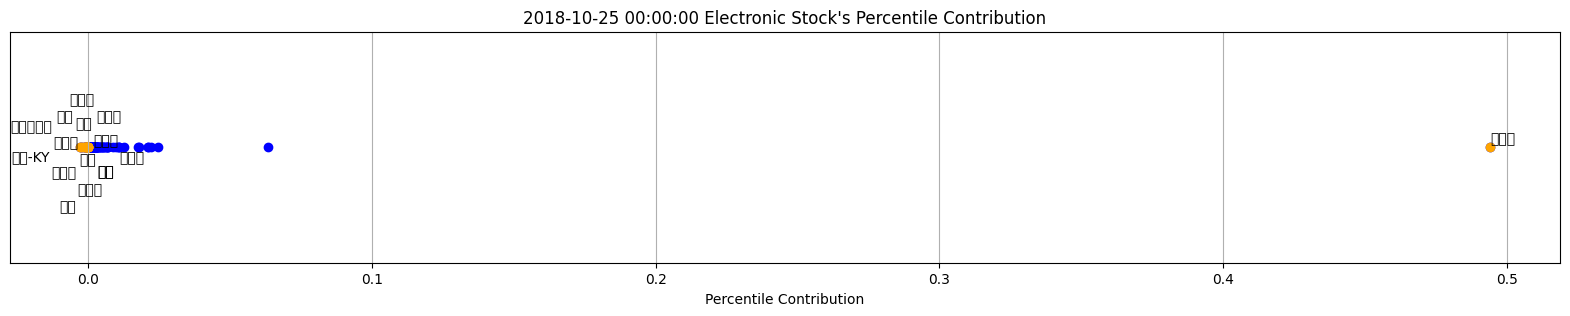

16 16


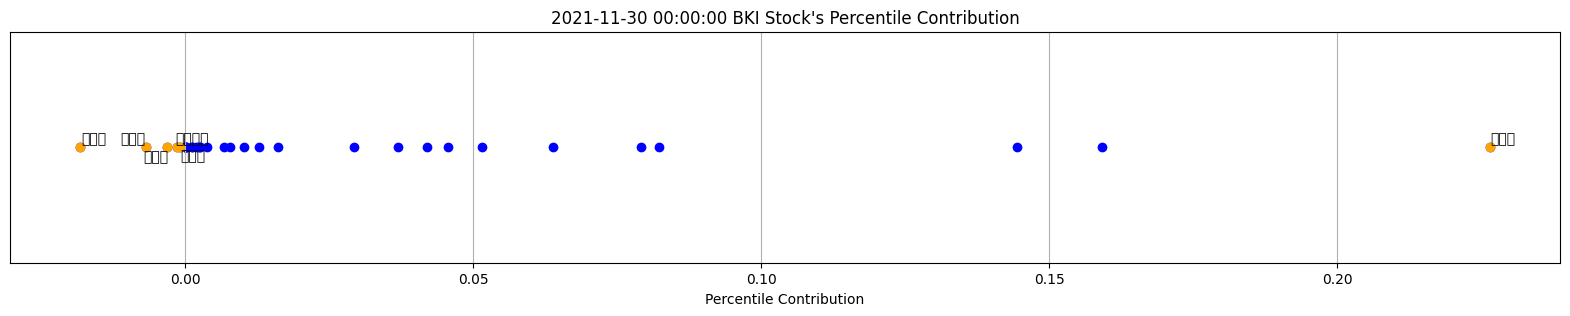

6 6


In [6]:
elec_date = np.random.choice(range(len(top_contributor_E['contributions'].index)))
bki_date = np.random.choice(range(len(top_contributor_E['contributions'].index)))

plt.figure(figsize=(20, 3))

plt.scatter(contribution_of_momentum_E_last_five_days_in_percent.iloc[[elec_date+minor_window]]
            , np.zeros_like(contribution_of_momentum_E_last_five_days_in_percent.iloc[[elec_date+minor_window]])
            , color='blue')

contributors =  top_contributor_E['contributors'].iloc[elec_date]
contributions = top_contributor_E['contributions'].iloc[elec_date]

texts = [] # list to store all the text instances

# plot and annotate each point
for contributor, contribution in zip(contributors, contributions):
    plt.scatter(contribution, 0, color='orange', label = "Top and Bottom 25% Contributors")
    texts.append(plt.text(contribution, 0, contributor, ha='center'))

adjust_text(texts)

plt.title(f"{top_contributor_E['contributions'].index[elec_date]} Electronic Stock's Percentile Contribution")
plt.xlabel("Percentile Contribution")

# hide y axis
plt.yticks([])
plt.grid()

plt.show()

print(len(contributors), len(contributions))

plt.figure(figsize=(20, 3))

plt.scatter(contribution_of_momentum_F_last_five_days_in_percent.iloc[[bki_date+minor_window]]
            , np.zeros_like(contribution_of_momentum_F_last_five_days_in_percent.iloc[[bki_date+minor_window]])
            , color='blue')

contributors =  top_contributor_F['contributors'].iloc[bki_date]
contributions = top_contributor_F["contributions"].iloc[bki_date]

texts = [] # list to store all the text instances

# plot and annotate each point
for contributor, contribution in zip(contributors, contributions):
    plt.scatter(contribution, 0, color='orange', label = "Top and Bottom 25% Contributors")
    texts.append(plt.text(contribution, 0, contributor, ha='center'))

adjust_text(texts)

plt.title(f"{top_contributor_E['contributions'].index[bki_date]} BKI Stock's Percentile Contribution")
plt.xlabel("Percentile Contribution")

# hide y axis
plt.yticks([])
plt.grid()

plt.show()
print(len(contributors), len(contributions))

# 0712
1. Calculate the "momentum(return)" of last five days
2. Calculate the "contribution" by "momentum(return)" X "weights".  
3. Convert "contribution" to "percentile contribution". 
4. Selected those stocks provide top 50% contribution (who contributed the 50% of momentum in last five days).
5. Estimation of the next day prices of selected stocks. 
6. Using the "updated weights"(modifying them to 100%) X estimated prices to get "estimated prices of EX / FX".
7. Comparison

## Momentum-Based Predictor Demonstration

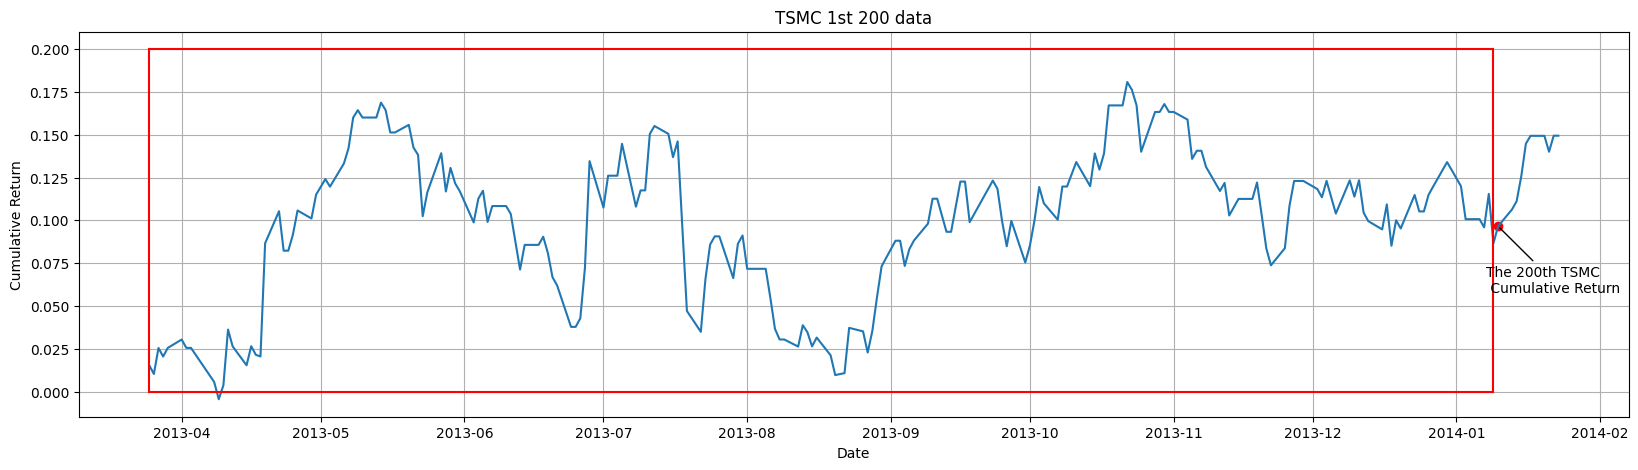

In [7]:
tsmc = cum_return_EF["台積電"]

ls = []
for i in np.linspace(0, 0.2, 1000): 
    ls.append(tsmc.index[0])

ls2 = []
for i in np.linspace(0, 0.2, 1000): 
    ls2.append(tsmc.index[199])

ls3 = []
for i in tsmc.index[0:200]: 
    ls3.append(0.2)

ls4 = []
for i in tsmc.index[0:200]: 
    ls4.append(0)

fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(tsmc[:210])
ax.plot(ls, np.linspace(0, 0.2, 1000), c = 'red')
ax.plot(ls2, np.linspace(0, 0.2, 1000), c = 'red')
ax.plot(tsmc.index[0:200], ls3, c = 'red')
ax.plot(tsmc.index[0:200], ls4, c = 'red')
ax.scatter(tsmc.index[200], tsmc[200], c = 'red')

texts = []
texts.append(ax.annotate('The 200th TSMC \n Cumulative Return', 
                         xy=(tsmc.index[200], tsmc[200]), 
                         xytext=(160,-50), 
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='-')))

adjust_text(texts)
ax.set_title("TSMC 1st 200 data")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
plt.grid()
plt.show()

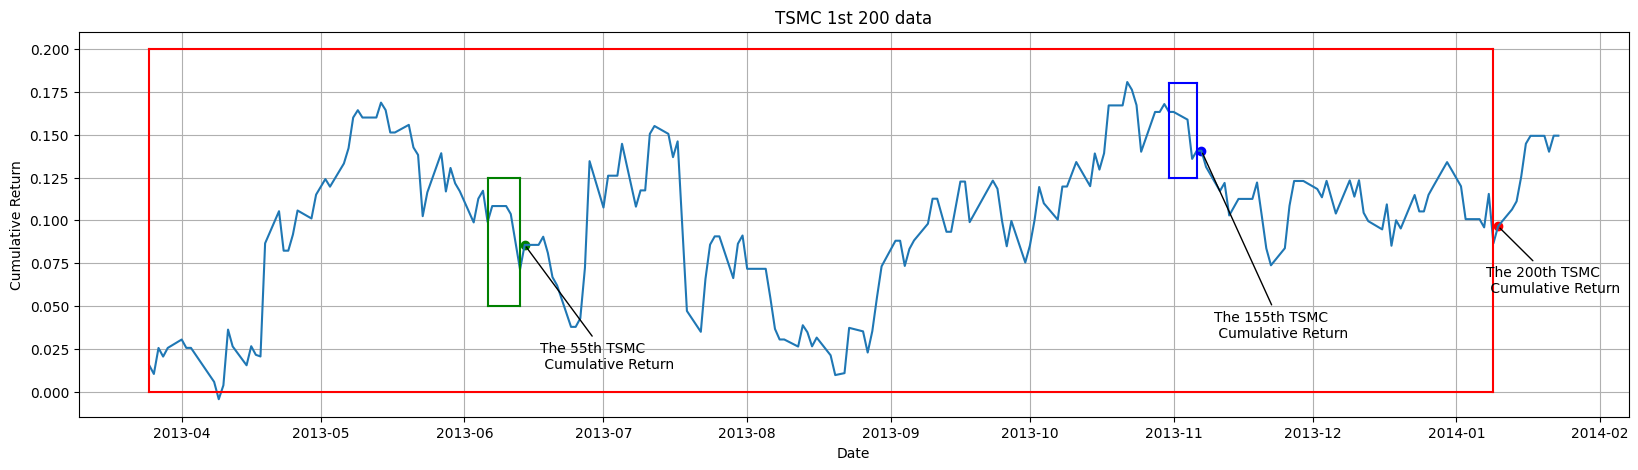

In [8]:
tsmc = cum_return_EF["台積電"]

ls = []
for i in np.linspace(0, 0.2, 1000): 
    ls.append(tsmc.index[0])

ls2 = []
for i in np.linspace(0, 0.2, 1000): 
    ls2.append(tsmc.index[199])

ls3 = []
for i in tsmc.index[0:200]: 
    ls3.append(0.2)

ls4 = []
for i in tsmc.index[0:200]: 
    ls4.append(0)
    
ls5 = []
for i in np.linspace(0, 0.2, 1000): 
    ls5.append(tsmc.index[50])
    
ls6 = []
for i in np.linspace(0, 0.2, 1000): 
    ls6.append(tsmc.index[54])
    
ls7 = []
for i in tsmc.index[50:55]: 
    ls7.append(0.125)

ls8 = []
for i in tsmc.index[50:55]: 
    ls8.append(0.05)
    
    
ls9 = []
for i in np.linspace(0, 0.2, 1000): 
    ls9.append(tsmc.index[150])
    
ls10 = []
for i in np.linspace(0, 0.2, 1000): 
    ls10.append(tsmc.index[154])
    
ls11 = []
for i in tsmc.index[150:155]: 
    ls11.append(0.18)

ls12 = []
for i in tsmc.index[150:155]: 
    ls12.append(0.125)

fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(tsmc[:210])
ax.plot(ls, np.linspace(0, 0.2, 1000), c = 'red')
ax.plot(ls2, np.linspace(0, 0.2, 1000), c = 'red')
ax.plot(tsmc.index[0:200], ls3, c = 'red')
ax.plot(tsmc.index[0:200], ls4, c = 'red')
ax.plot(ls5, np.linspace(0.05, 0.125, 1000), c = 'green')
ax.plot(ls6, np.linspace(0.05, 0.125, 1000), c = 'green')
ax.plot(tsmc.index[50:55], ls7, c = 'green')
ax.plot(tsmc.index[50:55], ls8, c = 'green')

ax.plot(ls9, np.linspace(0.125, 0.18, 1000), c = 'blue')
ax.plot(ls10, np.linspace(0.125, 0.18, 1000), c = 'blue')
ax.plot(tsmc.index[150:155], ls11, c = 'blue')
ax.plot(tsmc.index[150:155], ls12, c = 'blue')

ax.scatter(tsmc.index[200], tsmc[200], c = 'red')
ax.scatter(tsmc.index[55], tsmc[55], c = 'green')
ax.scatter(tsmc.index[155], tsmc[155], c = 'blue')

texts = []
texts.append(ax.annotate('The 200th TSMC \n Cumulative Return', 
                         xy=(tsmc.index[200], tsmc[200]), 
                         xytext=(160,-50), 
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='-')))

adjust_text(texts)

texts1 = []
texts1.append(ax.annotate('The 55th TSMC \n Cumulative Return', 
                         xy=(tsmc.index[55], tsmc[55]), 
                         xytext=(100,-100), 
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='-')))

adjust_text(texts1)

texts2 = []
texts2.append(ax.annotate('The 155th TSMC \n Cumulative Return', 
                         xy=(tsmc.index[155], tsmc[155]), 
                         xytext=(100,-150), 
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='-')))

adjust_text(texts2)

ax.set_title("TSMC 1st 200 data")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")

plt.grid()
plt.show()

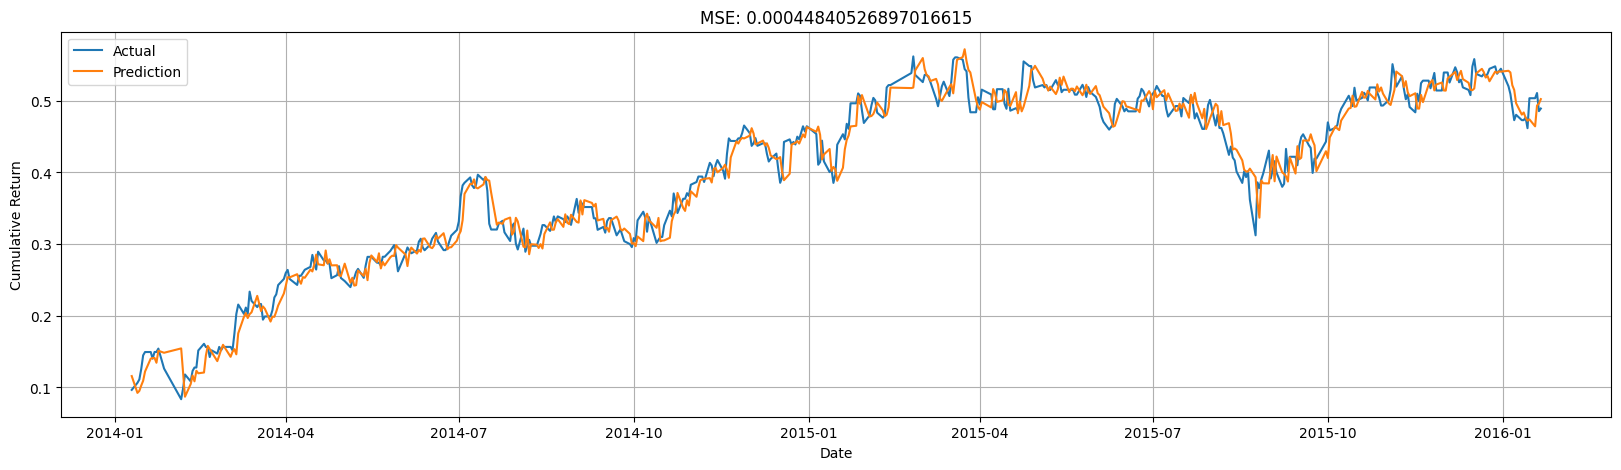

In [9]:
tsmc = cum_return_EF["台積電"]
x, y = LR_predictor(tsmc, minor_window)

plt.figure(figsize = (20, 5))
plt.title(f"MSE: {mean_squared_error(tsmc[200:], y)}")
plt.plot(x[:500], tsmc[200:][:500], label = "Actual")
plt.plot(x[:500], y[:500], label = "Prediction")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

# Momentum-Based Predictor

In [16]:
momentum_est_file = [f for f in os.listdir('./Data') if f == 'Momentum_Estimation.csv']
if len(momentum_est_file) == 0: 
    estimation_EF = pd.DataFrame()
    for column in cum_return_EF.columns:   
        data = cum_return_EF[column]
        x, y = LR_predictor(data, minor_window)
        df = pd.DataFrame(y, index = x, columns=[column])
        estimation_EF = pd.concat([estimation_EF, df], axis = 1, join='outer')
    estimation_EF.to_csv("Momentum_Estimation.csv", encoding = 'utf-8-sig')
else: 
    estimation_EF = pd.read_csv("./Data/Momentum_Estimation.csv", index_col=0)
    estimation_EF.index = pd.to_datetime(estimation_EF.index)

In [25]:
elec_score = []
bki_score = []
scoring_dates = estimation_EF.index
for date in estimation_EF.index:
    contributors_E = top_contributor_E['contributors'].loc[date]
    # if len(contributors_E) > 5:
    #     print(date, top_contributor_E['contributors'].loc[date],
    #           top_contributor_E["contributions"].loc[date])
    prediction_E = pd.DataFrame(estimation_EF[contributors_E].loc[date].values, 
                              index=contributors_E, columns=["Prediction"])
    original_weight_E = pd.DataFrame(daily_weights_E[contributors_E].loc[date].values, 
                              index=contributors_E, columns=["Original Weights"])
    pool_E = pd.concat([prediction_E, original_weight_E], axis=1, join="inner")
    pool_E["Weights"] = pool_E["Original Weights"] /  pool_E["Original Weights"].sum()
    pool_E['Scores'] = pool_E["Weights"] * pool_E["Prediction"]

    contributors_F = top_contributor_F['contributors'].loc[date]
    # if len(contributors_F) > 5:
    #     print(date, top_contributor_F['contributors'].loc[date],
    #           top_contributor_F["contributions"].loc[date])
    prediction_F = pd.DataFrame(estimation_EF[contributors_F].loc[date].values, 
                              index=contributors_F, columns=["Prediction"])
    original_weight_F = pd.DataFrame(daily_weights_F[contributors_F].loc[date].values, 
                              index=contributors_F, columns=["Original Weights"])
    pool_F = pd.concat([prediction_F, original_weight_F], axis=1, join="inner")
    pool_F["Weights"] = pool_F["Original Weights"] /  pool_F["Original Weights"].sum()
    pool_F['Scores'] = pool_F["Weights"] * pool_F["Prediction"]

    
    elec_score.append(pool_E["Scores"].sum())
    bki_score.append(pool_F["Scores"].sum())
    
scoring_pools = pd.DataFrame({
    "ELEC": elec_score, 
    "BKI": bki_score 
}, index = scoring_dates)

Index_LS_return = ((cum_return_EF[F_list] * daily_weights_F).sum(axis = 1))[200:].values - ((cum_return_EF[E_list] * daily_weights_E).sum(axis = 1))[200:].values * Ratio["Hedge Ratio"].values[200:]
Index_LS_return = pd.DataFrame(Index_LS_return, index = cum_return_EF.index[200:])
Index_LS_return.columns = ['Actual Return']

scoring_pools = pd.concat([scoring_pools, Ratio], axis = 1, join="inner")
scoring_pools["Signals"] = scoring_pools["BKI"] - scoring_pools["ELEC"] * scoring_pools["Hedge Ratio"]
scoring_pools = pd.concat([scoring_pools, Index_LS_return['Actual Return']], axis = 1, join="inner")
scoring_pools

,ELEC,BKI,Hedge Ratio,Signals,Actual Return
2014-01-10,0.129423,0.184534,0.609366,0.105668,0.068128
2014-01-13,0.103390,0.215045,0.604104,0.152587,0.062358
2014-01-14,0.107254,0.096659,0.60541,0.031726,0.064924
2014-01-15,0.117073,0.091047,0.602685,0.020489,0.057232
2014-01-16,0.111894,0.097469,0.596592,0.030714,0.051907
...,...,...,...,...,...
2023-07-03,2.252470,1.066090,0.367107,0.239191,0.337816
2023-07-04,2.217136,1.115778,0.367519,0.300938,0.337474
2023-07-05,2.205939,1.053201,0.36519,0.247615,0.339573
2023-07-06,1.837164,1.008263,0.362364,0.342541,0.352018


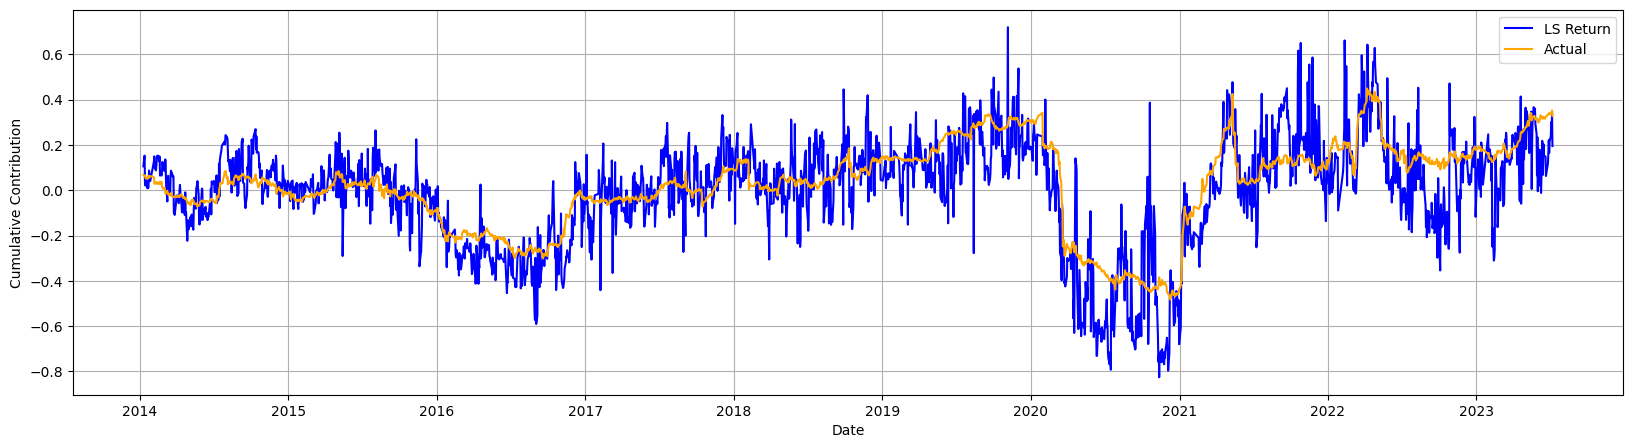

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(scoring_pools['Signals'], label = 'LS Return', c = "blue")
plt.plot(scoring_pools['Actual Return'], label = "Actual", c = "orange")
plt.legend()
# plt.title(f"Estimated Trend: {mean_squared_error(scoring_pool['Signals'].values, Index_LS_return)}")
plt.xlabel("Date")
plt.ylabel("Cumulative Contribution")
plt.grid()
plt.show()

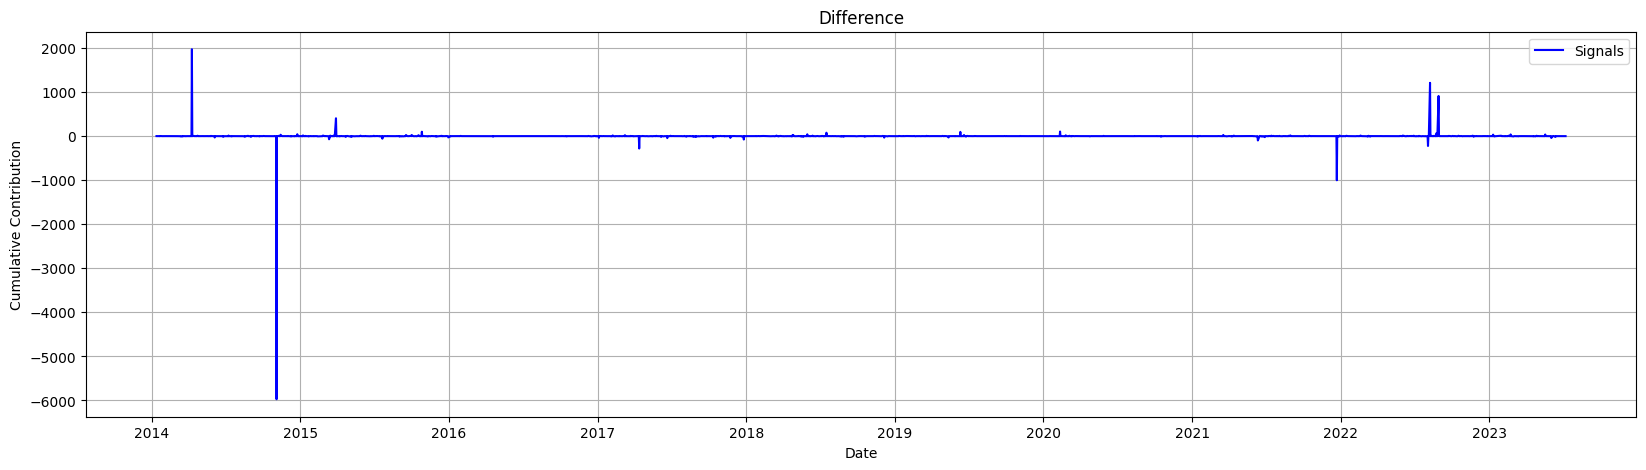

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(scoring_pools['Signals'].pct_change(), label = 'Signals', c = "blue")
plt.legend()
plt.title(mean_squared_error(scoring_pools['Signals'],Index_LS_return ))
plt.title("Difference")
plt.xlabel("Date")
plt.ylabel("Cumulative Contribution")
plt.grid()
plt.show()

In [14]:
scoring_pools["Actual"] = Index_LS_return
scoring_pools["DIFF"] = scoring_pools['LS Strategy Return'].diff()
scoring_pools.dropna(inplace=True)

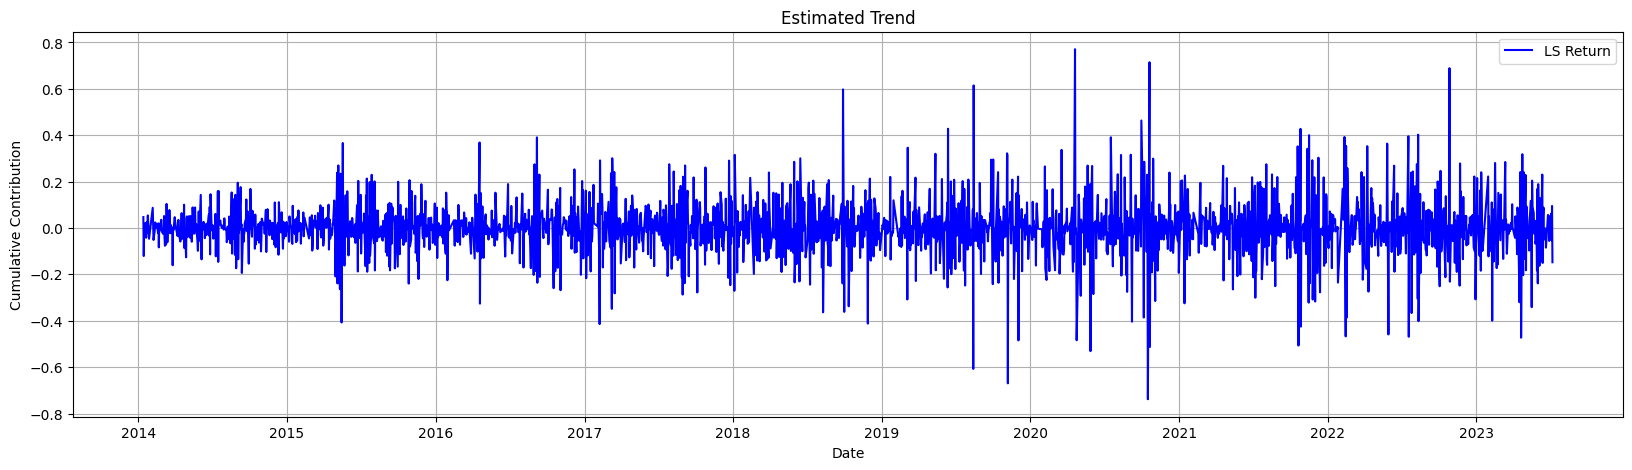

In [32]:
scoring_pools["Signals DIFF"] = scoring_pools["Signals"].diff()
plt.figure(figsize=(20, 5))
plt.plot(scoring_pools["Signals DIFF"], label = 'LS Return', c = "blue")
plt.legend()
plt.title("Estimated Trend")
plt.xlabel("Date")
plt.ylabel("Cumulative Contribution")
plt.grid()
plt.show()

# Numerical Analysis

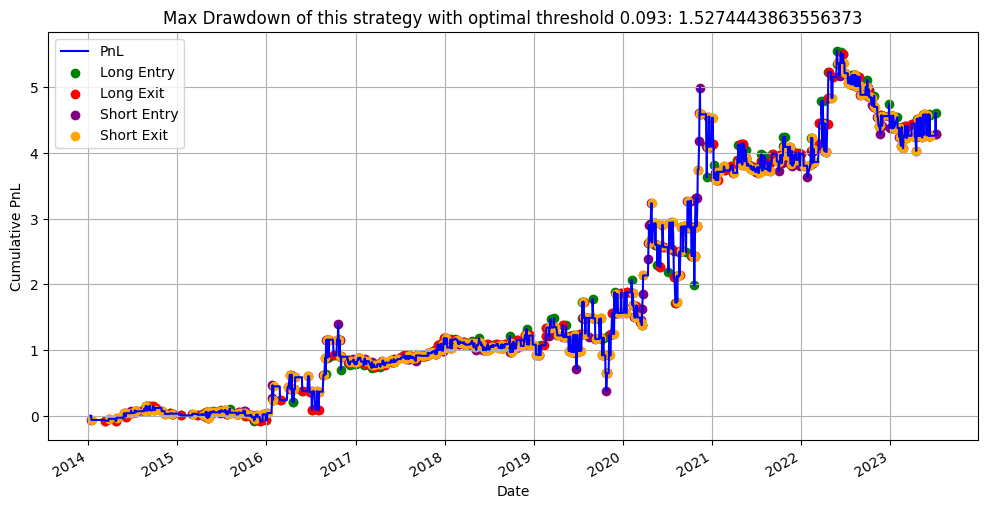

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your dataframe
df = scoring_pools.copy()

# Function to calculate pnl and mdd for a given threshold
def calculate_pnl_mdd(df, threshold):
    df['pnl'] = 0
    df.loc[df['Signals DIFF'] > threshold, 'pnl'] = df.loc[df['Signals DIFF'] > threshold, 'Actual Return']
    df.loc[df['Signals DIFF'] < -threshold, 'pnl'] = -df.loc[df['Signals DIFF'] < -threshold, 'Actual Return']

    df['cumulative_pnl'] = df['pnl'].cumsum()
    df['running_max'] = np.maximum.accumulate(df['cumulative_pnl'])
    df['drawdown'] = df['running_max'] - df['cumulative_pnl']

    max_drawdown = df['drawdown'].max()
    final_pnl = df['cumulative_pnl'].iloc[-1]

    return final_pnl, max_drawdown

# Grid search over potential threshold values
thresholds = np.arange(0.001, 0.2, 0.001)  # Adjust the range and step size as necessary
results = []
for threshold in thresholds:
    pnl, mdd = calculate_pnl_mdd(df, threshold)
    results.append((threshold, pnl, mdd))

# Convert results to a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['threshold', 'pnl', 'mdd'])

# Filter for scenarios where pnl is positive
results_df = results_df[results_df['pnl'] > 0]

# Find the threshold that minimizes mdd
optimal_threshold = results_df.loc[results_df['mdd'].idxmin(), 'threshold']

# Calculate PnL and MDD using the optimal threshold
final_pnl, max_drawdown = calculate_pnl_mdd(df, optimal_threshold)

# Plot the optimal strategy
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative PnL
df['cumulative_pnl'].plot(ax=ax, color='blue', label='PnL')

# Mark the entry and exit points for plotting
entry_long = df[df['Signals DIFF'] > optimal_threshold]
exit_long = df[(df['Signals DIFF'] <= optimal_threshold) & (df['Signals DIFF'].shift(1) > optimal_threshold)]

entry_short = df[df['Signals DIFF'] < -optimal_threshold]
exit_short = df[(df['Signals DIFF'] >= -optimal_threshold) & (df['Signals DIFF'].shift(1) < -optimal_threshold)]

ax.scatter(entry_long.index, entry_long['cumulative_pnl'], color='green', label='Long Entry')
ax.scatter(exit_long.index, exit_long['cumulative_pnl'], color='red', label='Long Exit')
ax.scatter(entry_short.index, entry_short['cumulative_pnl'], color='purple', label='Short Entry')
ax.scatter(exit_short.index, exit_short['cumulative_pnl'], color='orange', label='Short Exit')

ax.set_title(f'Max Drawdown of this strategy with optimal threshold {optimal_threshold}: {max_drawdown}')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL')
ax.grid(True)
ax.legend()

plt.show()


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your dataframe
df = scoring_pools.copy()

# Function to calculate pnl, mdd, and trade counts for a given threshold
def calculate_pnl_mdd_counts(df, threshold):
    df['pnl'] = 0
    df.loc[df['Signals DIFF'] > threshold, 'pnl'] = df.loc[df['Signals DIFF'] > threshold, 'Actual Return']
    df.loc[df['Signals DIFF'] < -threshold, 'pnl'] = -df.loc[df['Signals DIFF'] < -threshold, 'Actual Return']

    df['cumulative_pnl'] = df['pnl'].cumsum()
    df['running_max'] = np.maximum.accumulate(df['cumulative_pnl'])
    df['drawdown'] = df['running_max'] - df['cumulative_pnl']

    max_drawdown = df['drawdown'].max()
    final_pnl = df['cumulative_pnl'].iloc[-1]

    # Count the number of long and short entries and exits
    long_entries = sum(df['Signals DIFF'] > threshold)
    long_exits = sum((df['Signals DIFF'] <= threshold) & (df['Signals DIFF'].shift(1) > threshold))
    short_entries = sum(df['Signals DIFF'] < -threshold)
    short_exits = sum((df['Signals DIFF'] >= -threshold) & (df['Signals DIFF'].shift(1) < -threshold))

    return final_pnl, max_drawdown, long_entries, long_exits, short_entries, short_exits

# Grid search over potential threshold values
thresholds = np.arange(0.001, 0.2, 0.001)  # Adjust the range and step size as necessary
results = []
for threshold in thresholds:
    pnl, mdd, le, lx, se, sx = calculate_pnl_mdd_counts(df, threshold)
    results.append((threshold, pnl, mdd, le, lx, se, sx))

# Convert results to a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['threshold', 'pnl', 'mdd', 'long_entries', 'long_exits', 'short_entries', 'short_exits'])

# Filter for scenarios where pnl is positive
results_df = results_df[results_df['pnl'] > 0]

# Find the threshold that minimizes mdd
optimal_threshold = results_df.loc[results_df['mdd'].idxmin(), 'threshold']

# Calculate PnL, MDD, and counts using the optimal threshold
final_pnl, max_drawdown, long_entries, long_exits, short_entries, short_exits = calculate_pnl_mdd_counts(df, optimal_threshold)

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Final PnL: {final_pnl}')
print(f'Max Drawdown: {max_drawdown}')
print(f'Number of Long Entries: {long_entries}')
print(f'Number of Long Exits: {long_exits}')
print(f'Number of Short Entries: {short_entries}')
print(f'Number of Short Exits: {short_exits}')


Optimal Threshold: 0.093
Final PnL: 4.2872507479249915
Max Drawdown: 1.5274443863556373
Number of Long Entries: 333
Number of Long Exits: 305
Number of Short Entries: 343
Number of Short Exits: 314


Optimal Threshold: 0.19
Final PnL: 4.267106388211893
Max Drawdown: 1.812572467469961
Number of Long Entries: 106
Number of Long Exits: 106
Number of Short Entries: 76
Number of Short Exits: 76


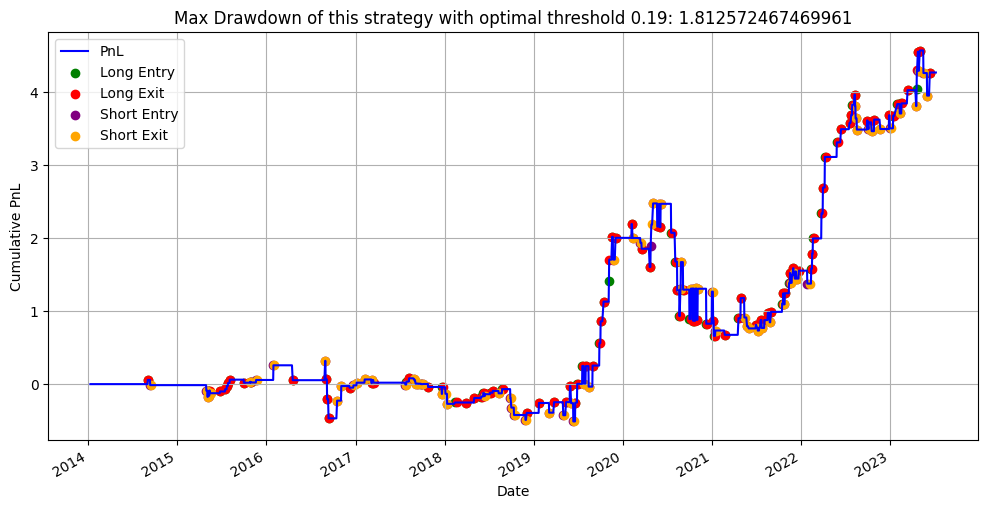

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your dataframe
df = scoring_pools.copy()

def calculate_pnl_mdd_counts(df, threshold):
    df['pnl'] = 0
    df['position'] = 0  # Position status
    df['entry_exit'] = 0  # Mark entries and exits

    for i in range(1, len(df)):
        # Check if we need to exit
        if df['position'].iloc[i-1] == 1 and df['Signals DIFF'].iloc[i] <= threshold:
            df['position'].iloc[i] = 0
            df['entry_exit'].iloc[i] = -1
        elif df['position'].iloc[i-1] == -1 and df['Signals DIFF'].iloc[i] >= -threshold:
            df['position'].iloc[i] = 0
            df['entry_exit'].iloc[i] = 1
        # Or enter a position
        elif df['position'].iloc[i-1] == 0 and df['Signals DIFF'].iloc[i] > threshold:
            df['position'].iloc[i] = 1
            df['entry_exit'].iloc[i] = 1
        elif df['position'].iloc[i-1] == 0 and df['Signals DIFF'].iloc[i] < -threshold:
            df['position'].iloc[i] = -1
            df['entry_exit'].iloc[i] = -1
        # Or continue holding
        else:
            df['position'].iloc[i] = df['position'].iloc[i-1]
        
        # Calculate PnL
        df['pnl'].iloc[i] = df['position'].iloc[i] * df['Actual Return'].iloc[i]

    df['cumulative_pnl'] = df['pnl'].cumsum()
    df['running_max'] = np.maximum.accumulate(df['cumulative_pnl'])
    df['drawdown'] = df['running_max'] - df['cumulative_pnl']

    max_drawdown = df['drawdown'].max()
    final_pnl = df['cumulative_pnl'].iloc[-1]

    # Count the number of long and short entries and exits
    long_entries = sum((df['entry_exit'] == 1) & (df['position'] == 1))
    long_exits = sum((df['entry_exit'] == -1) & (df['position'] == 0) & (df['position'].shift() == 1))
    short_entries = sum((df['entry_exit'] == -1) & (df['position'] == -1))
    short_exits = sum((df['entry_exit'] == 1) & (df['position'] == 0) & (df['position'].shift() == -1))

    return final_pnl, max_drawdown, long_entries, long_exits, short_entries, short_exits

# Grid search over potential threshold values
thresholds = np.arange(0.01, 0.2, 0.01)  # Adjust the range and step size as necessary
results = []
for threshold in thresholds:
    pnl, mdd, le, lx, se, sx = calculate_pnl_mdd_counts(df.copy(), threshold)
    results.append((threshold, pnl, mdd, le, lx, se, sx))

# Convert results to a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['threshold', 'pnl', 'mdd', 'long_entries', 'long_exits', 'short_entries', 'short_exits'])

# Filter for scenarios where pnl is positive
results_df = results_df[results_df['pnl'] > 0]

# Find the threshold that minimizes mdd
optimal_threshold = results_df.loc[results_df['mdd'].idxmin(), 'threshold']

# Calculate PnL, MDD, and counts using the optimal threshold
final_pnl, max_drawdown, long_entries, long_exits, short_entries, short_exits = calculate_pnl_mdd_counts(df, optimal_threshold)

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Final PnL: {final_pnl}')
print(f'Max Drawdown: {max_drawdown}')
print(f'Number of Long Entries: {long_entries}')
print(f'Number of Long Exits: {long_exits}')
print(f'Number of Short Entries: {short_entries}')
print(f'Number of Short Exits: {short_exits}')

# Plot the optimal strategy
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative PnL
df['cumulative_pnl'].plot(ax=ax, color='blue', label='PnL')

# Mark the entry and exit points for plotting
long_entry_points = df[(df['entry_exit'] == 1) & (df['position'] == 1)]
long_exit_points = df[(df['entry_exit'] == -1) & (df['position'].shift() == 1)]
short_entry_points = df[(df['entry_exit'] == -1) & (df['position'] == -1)]
short_exit_points = df[(df['entry_exit'] == 1) & (df['position'].shift() == -1)]

ax.scatter(long_entry_points.index, long_entry_points['cumulative_pnl'], color='green', label='Long Entry')
ax.scatter(long_exit_points.index, long_exit_points['cumulative_pnl'], color='red', label='Long Exit')
ax.scatter(short_entry_points.index, short_entry_points['cumulative_pnl'], color='purple', label='Short Entry')
ax.scatter(short_exit_points.index, short_exit_points['cumulative_pnl'], color='orange', label='Short Exit')

ax.set_title(f'Max Drawdown of this strategy with optimal threshold {optimal_threshold}: {max_drawdown}')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL')
ax.grid(True)
ax.legend()

plt.show()
